In [1]:
import netket as nk
import numpy as np

2022-03-31 00:44:56.843139: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 00:44:57.020363: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 00:44:57.023023: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
#晶格相互作用对定义
size = (5,5)
row_num, col_num = size
n_lattice = row_num * col_num
num = [ i for i in range(row_num * col_num)]

begin = [ i * col_num for i in range(row_num)]
end = [(i + 1) * col_num - 1 for i in range(row_num)]

In [3]:
edgesx = []
edgesy = []
edgesz = []

In [4]:
for i in num:
    if i in begin:
        edgesx.append([i, i + col_num - 1])
    else:
        edgesx.append([i, i - 1])

for i in num:
    if i in num [ :col_num]:
        edgesy.append([i, num[- (col_num - i)]])
    else:
        edgesy.append([i, i - col_num])

for i in num:
    if i in num [-col_num:-1]:
        edgesz.append([i, num[- (col_num*3 - i)]+1])
    elif i in end:
        if i==n_lattice-1:
            edgesz.append([0, i])
        else:
            edgesz.append([i, i + 1])     
    else:
        edgesz.append([i, i + col_num + 1])

edges = edgesx + edgesz + edgesy
graph = nk.graph.Graph(edges)
graph.nodes()

range(0, 25)

hilbert space

In [5]:
#希尔伯特空间
hi = nk.hilbert.Spin(s = 0.5, N = graph.n_nodes)

哈密顿量

In [6]:
#pauli matrix
sx = [[0, 1], [1, 0]]
sy = [[0, -1j], [1j, 0]]
sz = [[1, 0], [0, -1]]
#parameter
h=1
J=1
#g = J / h
H = nk.operator.LocalOperator(hi)
for i in edges:
    H += -J*nk.operator.LocalOperator(hi, np.kron(sz, sz), i)
sxx = -h* nk.operator.LocalOperator(hi, [sx] * n_lattice, [[i] for i in range(n_lattice)])
H += sxx #This term is magnetization, which can be regarded as an operator Mx(g)


In [7]:
H

LocalOperator(dim=25, #acting_on=100 locations, constant=0, dtype=float64)

In [8]:
#精确对角化（5x5时会崩溃）
#sp_h=H.to_sparse()
#sp_h.shape

# the k-th lowest eigenvalues
#from scipy.sparse.linalg import eigsh

#eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

#print("eigenvalues with scipy sparse:", eig_vals)

#E_gs = eig_vals[0]

In [9]:
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax  

In [10]:
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        lam = self.param(
            "lambda", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(lam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

In [11]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
mf_model=MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=512)

2022-03-31 00:45:01.672205: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 00:45:01.672261: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
#神经网络量子态
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
                
        # sum the output
        return jnp.sum(y, axis=-1)
    
class FFNN(nn.Module):
    @nk.nn.compact
    def __call__(self, x):
        x = nk.nn.Dense(features=2*x.shape[-1], 
                       use_bias=True, 
                       dtype=np.complex128, 
                       kernel_init=nn.initializers.normal(stddev=0.01), 
                       bias_init=nn.initializers.normal(stddev=0.01)
                      )(x)
        x = nk.nn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x


class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.log_softmax(x)
    return x

#model = FFNN()
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [13]:
optimizer = nk.optimizer.Sgd(learning_rate=0.01)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.01))

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
#error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",ffn_energy)

100%|██████████| 1000/1000 [00:31<00:00, 31.79it/s, Energy=-77.1004 ± 0.0059 [σ²=0.0347, R̂=1.0015]]


Optimized energy and relative error:  -77.1045 ± 0.0070 [σ²=0.0499, R̂=0.9988]


Text(0, 0.5, 'Energy')

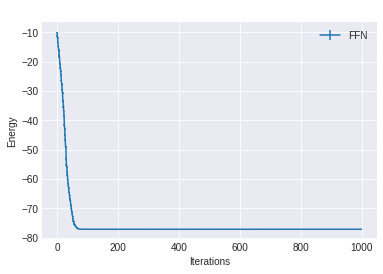

In [15]:
from matplotlib import pyplot as plt

data_FFN = log.data

plt.errorbar(data_FFN["Energy"].iters, data_FFN["Energy"].Mean, yerr=data_FFN["Energy"].Sigma, label="FFN")
#plt.hlines([E_gs], xmin=0, xmax=100, color='black', label="Exact")
from jupyterthemes import jtplot
#jtplot.style(theme='onedork') #选择一个绘图主题

plt.legend()
plt.style.use('seaborn-darkgrid') # 设置画图的风格 
plt.title(" ")
plt.xlabel('Iterations')
plt.ylabel('Energy')